# Image Colorization using CNNs - Regression model

The goal of this project is to colorize grayscale images using Convolutional Neural Networks. The model is trained on the [CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset, which contains over 200,000 celebrity portraits images.

In this first part, we will train a regression model to predict the ab channels of the Lab color space from the L channel. The [LAB color space](https://en.wikipedia.org/wiki/CIELAB_color_space) has the property of separating the luminance (brightness) channel from the chrominance channels (color). The L channel encodes the brightness of the image, while the ab channels encode the color information. By doing so the model will have to predict only two channels (AB) instead of three (RGB), which will make the training process faster.

## 1. Setup: Imports and parameters

First we get the dataset from the Shared Google Drive and we unzip it in the current directory for faster access. We created a subset of the dataset containing 10k images for training, 1k for validation and 1k for testing. The unzipped dataset will have the following structure:

```bash
.
├── celeba10k
│   ├── train
│   │   ├── 000001.jpg
│   │   ├── 000002.jpg
│   │   ├── ...
│   ├── validation
│   │   ├── 000001.jpg
│   │   ├── 000002.jpg
│   │   ├── ...
│   ├── test
│   │   ├── 000001.jpg
│   │   ├── 000002.jpg
│   │   ├── ...
```

In [ ]:
!unzip /content/drive/Shareddrives/Intelligent\ Systems/celeba10k.zip -d . | wc -l

12004


In [ ]:
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer, BatchNormalization, Lambda
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import tensorflow as tf
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from pathlib import Path
import time

In [ ]:
CELEBA_DIR = Path('/content/celeba10k')
DRIVE_DIR = Path('/content/drive/Shareddrives/Intelligent Systems') # for persistent storage
MODELS_DIR = DRIVE_DIR / 'models'
RESULTS_DIR = DRIVE_DIR / 'results'

batch_size = 16

# image width and height
H, W = (216, 176)

In [ ]:
# import the dataset as a tf.data.Dataset object and normalize the images to [0, 1]
dataset_from_directory_kwargs = {
    'labels': None,
    'image_size':(H, W),
    'seed': 42,
    'batch_size': batch_size
}

train_dataset = tf.keras.utils.image_dataset_from_directory(CELEBA_DIR / 'train', **dataset_from_directory_kwargs).map(lambda x: x/255)
val_dataset = tf.keras.utils.image_dataset_from_directory(CELEBA_DIR / 'validation', **dataset_from_directory_kwargs).map(lambda x: x/255)
test_dataset = tf.keras.utils.image_dataset_from_directory(CELEBA_DIR / 'test', **dataset_from_directory_kwargs).map(lambda x: x/255)

Found 10000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.


After the dataset is loaded we display some sample images, the function below will be used to display batches of images in the notebook.

In [ ]:
def show_imgs(imgs, *, ncols=1, save_path=None):
  """Utility function to show images in a grid arrangement."""

  imgs_iter = iter(imgs)

  dpi = 80
  N, h, w, _ = imgs.shape
  fig_width = (w*ncols)/dpi
  fig_height = (h*N//ncols)/dpi

  fig, ax_rows = plt.subplots(nrows=N//ncols, ncols=ncols, dpi=dpi, figsize=(fig_width, fig_height))

  for ax_col in ax_rows:
    for ax in ax_col:
      ax.imshow(next(imgs_iter))
      ax.axis('off')

  if save_path:
    plt.savefig(save_path.format(time=time.time_ns()))
  plt.show()

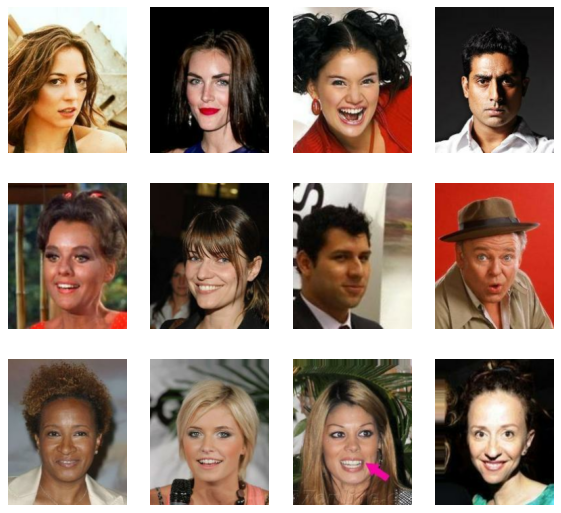

In [ ]:
imgs = next(test_dataset.rebatch(12).as_numpy_iterator())
show_imgs(imgs, ncols=4)

## 2. Data preparation

The images are loaded as RGB, we need to convert them to Lab and extract the L channel (brightness) and the ab channels (color). We will use the [OpenCV](https://opencv.org/) library to convert the images to Lab and extract the channels.

The L channel is normalized to the range [0, 1] and the ab channels are normalized to the range [-1, 1] (the values of the L channel are in the range [0, 100] and the values of the ab channels are in the range [-128, 127])

Since we can't load the entire dataset in memory, we will use a generator to load the images in batches. The generator will also perform the preprocessing steps described above, as per documentation, the generator must return a tuple `(inputs, targets)` where `inputs` is a list of input data arrays and `targets` is a list of target data arrays. Both lists must have the same length, that is the batch size.

In [ ]:
def prepare(dataset):
  for batch in dataset.as_numpy_iterator():
    # shape is (batch, H, W, rgb:3)
    batch = rgb2lab(batch)
    Xs = batch[...,0] / 100 # L channel
    Ys = batch[...,1:] / 128 # ab channels

    # reshape X to (batch, H, W, 1)
    yield Xs[...,np.newaxis], Ys

#Xs, Ys = next(train_data_generator())
#print(Xs.max(), Xs.min())
#print(Ys.max(), Ys.min())

## 3. Model

The model is a simple CNN Autoencoder, the encoder part is a series of `Conv2D` layers with `ReLU` activation, downsampling is performed using a stride of 2. The decoder part is a series of `Conv2D` layers with `ReLU` activation, upsampling is performed using `UpSampling2D`.

The activation function of the last layer in `tanh`, which works well for the ab channels since the values are in the range [-1, 1].

The loss function is the mean squared error between the predicted ab channels and the ground truth ab channels.

In [ ]:
model = Sequential()

model.add(InputLayer(input_shape=(H, W, 1)))

# encoder
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

# decoder
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

model.compile(optimizer='rmsprop', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 216, 176, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 88, 32)       9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 88, 64)       18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 54, 44, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 54, 44, 128)       73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 27, 22, 128)       147584    
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 22, 256)       2

## 4. Training

The model is trained for 30 epochs using the RMSprop optimizer with default parameters, we observed that the validation loss plateaus after 30 epochs.

One thing to note is that we must call the `.repeat()` method on the training dataset, otherwise the training will stop after one epoch.

In [ ]:
# Define the number of epochs
num_epochs = 30

model_checkpoint = ModelCheckpoint(str(MODELS_DIR / 'model_regr_small_b16_rmsprop_mse_{epoch:02d}.keras'))

history = model.fit(
    prepare(train_dataset.repeat()),
    epochs=num_epochs,
    validation_data=prepare(val_dataset.repeat()),
    callbacks = [model_checkpoint],
    steps_per_epoch = len(train_dataset),
    validation_steps = len(val_dataset)
)

Epoch 1/30
625/625 [==============================] - 93s 138ms/step - loss: 0.0090 - val_loss: 0.0085
Epoch 2/30
625/625 [==============================] - 83s 133ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 3/30
625/625 [==============================] - 78s 126ms/step - loss: 0.0080 - val_loss: 0.0080
Epoch 4/30
625/625 [==============================] - 81s 130ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 5/30
625/625 [==============================] - 78s 125ms/step - loss: 0.0078 - val_loss: 0.0079
Epoch 6/30
625/625 [==============================] - 80s 129ms/step - loss: 0.0077 - val_loss: 0.0084
Epoch 7/30
625/625 [==============================] - 75s 120ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 8/30
625/625 [==============================] - 77s 124ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 9/30
625/625 [==============================] - 82s 131ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 10/30
625/625 [==============================] - 71s 113ms/step - l

## 5. Results

We display some sample images from the test set, the images are displayed in groups of three, the first image is the grayscale input, the second image is the predicted image and the third image is the ground truth.

In [ ]:
model = tf.keras.models.load_model(str(MODELS_DIR / 'model_small_{epoch:02d}.keras').format(epoch=30))

In [ ]:
# take an arbitrary-sized batch from the test dataset
rgb = next(test_dataset.rebatch(21).as_numpy_iterator())

1/1 [==============================] - 0s 32ms/step


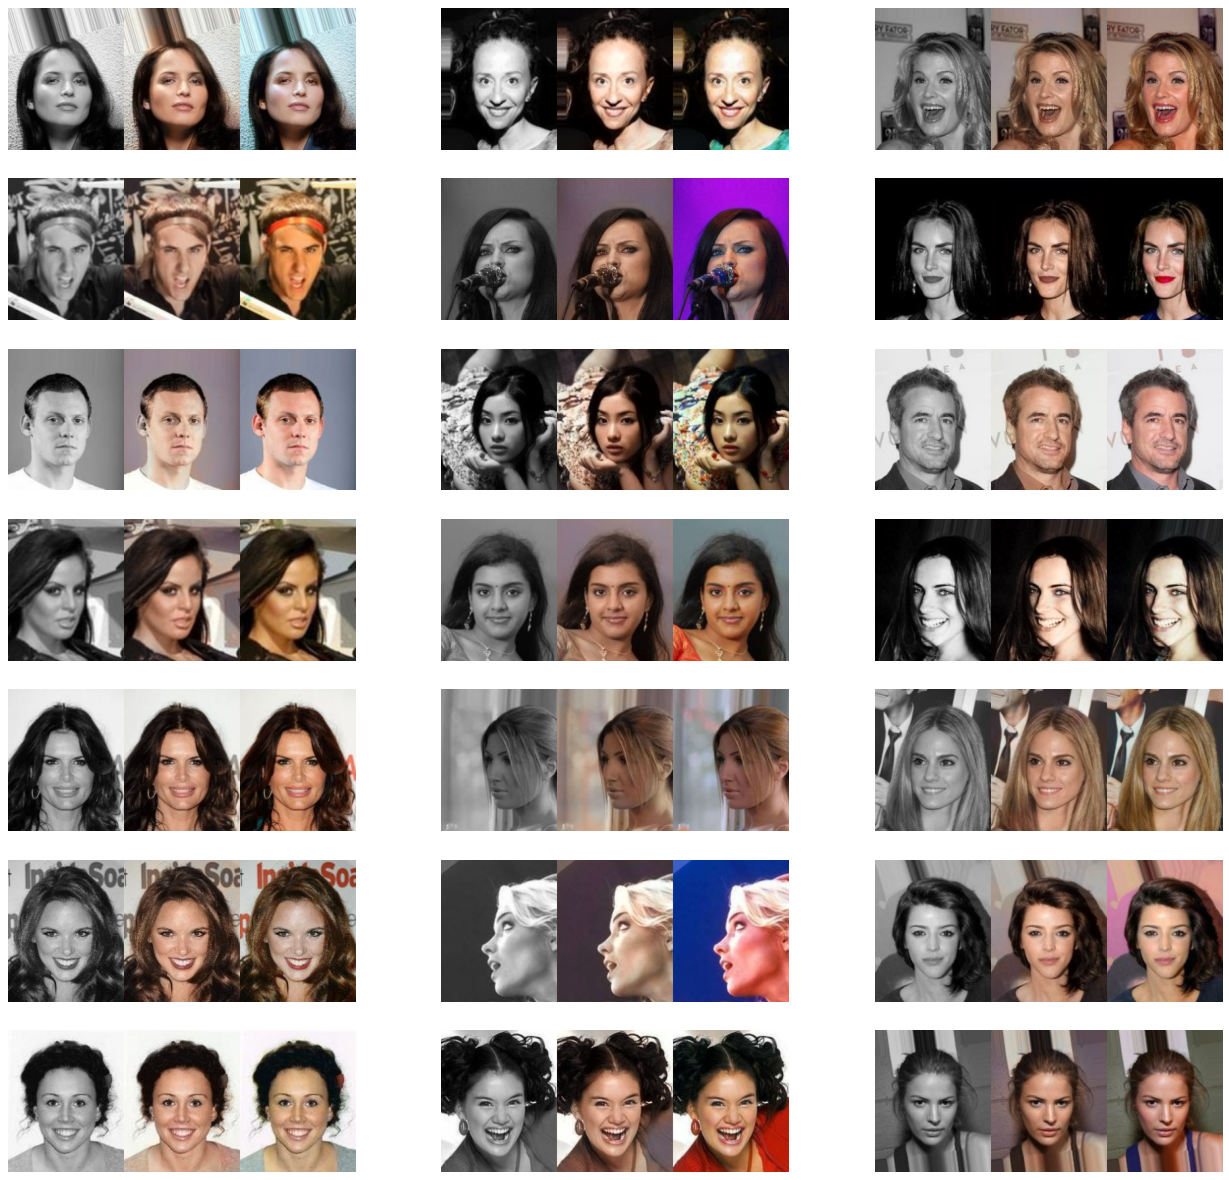

In [ ]:
lab = rgb2lab(rgb)
Lch = lab[...,0]

X = Lch[...,np.newaxis] / 100.
Y = model.predict(X)
ABch = Y * 128.

# construct image with predicted AB channels
colorized = np.zeros(rgb.shape)
colorized[...,0] = Lch
colorized[...,1:] = ABch

# AB channels = 0 -> bnw
lab[...,1:] = 0

grayscale = lab2rgb(lab)
colorized = lab2rgb(colorized)
imgs = np.concatenate([grayscale, colorized, rgb], axis=2)

show_imgs(imgs, ncols=3, save_path=str(RESULTS_DIR / 'colorized_regr_small_b16_rmsprop_mse_{time:x}.png'))

## 6. Evaluation

Unfortunately is hard to find a metric to evaluate the performance of the model, since the problem of colorization is by nature ambiguous. In many instances the model will predict a color that is different from the ground truth, but still plausible. There are even some cases where the model predicts a colorization that looks more natural than the ground truth (in cases where the white balance of the image is off for example).

That being said, we can see that the model tends to predict desaturated colors and it never predicts bright colors. We can see this clearly in the scatter plot below, where the predicted ab channels are plotted against the ground truth ab channels. The plot shows that the model tends to predict colors that are close to the origin, which means that the colors are desaturated.

There are a few reasons why the model tends to predict desaturated colors, we will address them in the next part of the project.

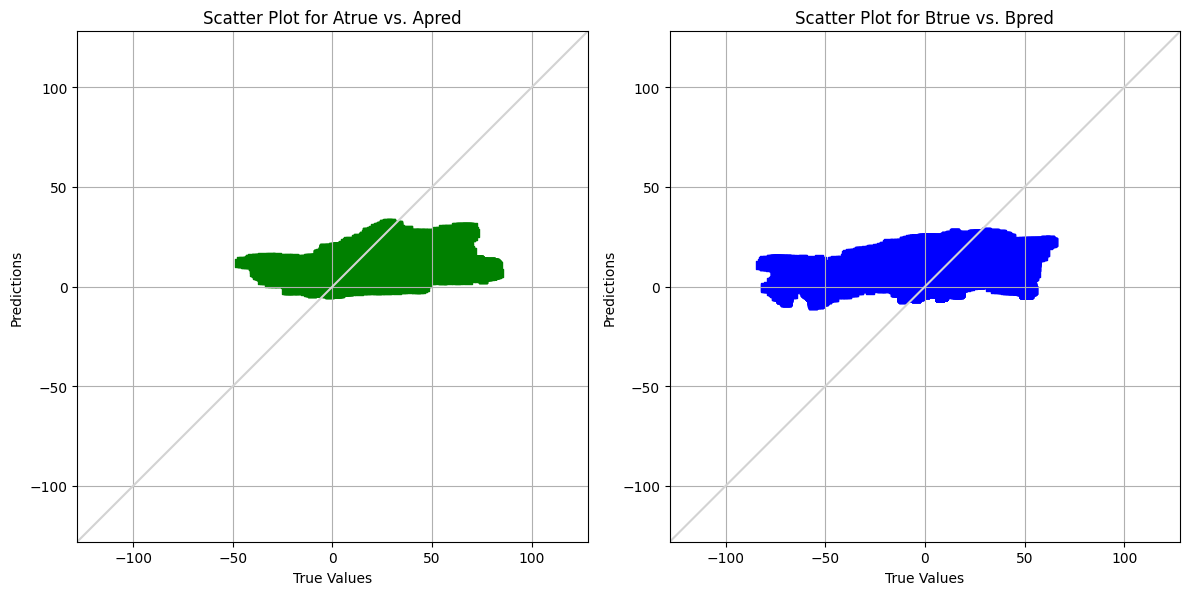

In [ ]:
lab = rgb2lab(rgb)
Atrue = lab[...,1]
Btrue = lab[...,2]

Apred = ABch[...,0]
Bpred = ABch[...,1]

# Create side-by-side scatter plots
plt.figure(figsize=(12, 6))
lims = [-128, 128]

# Plot for Atrue and Apred
plt.subplot(1, 2, 1, aspect='equal')
plt.plot(lims, lims, color='lightgray') # y=x line
plt.scatter(Atrue, Apred, marker=',', color='g')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter Plot for Atrue vs. Apred')
plt.xlim(lims)
plt.ylim(lims)
plt.grid(True)

# Plot for Btrue and Bpred
plt.subplot(1, 2, 2, aspect='equal')
plt.plot(lims, lims, color='lightgray') # y=x line
plt.scatter(Btrue, Bpred, marker=',', color='b')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter Plot for Btrue vs. Bpred')
plt.xlim(lims)
plt.ylim(lims)
plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlapping

# Show the plots
plt.show()